In [170]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [171]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
df_in = pd.read_excel('/content/drive/MyDrive/finaldatabase_V8.xlsx')  
df_in


,Size,Dose,P_density,CSKKKK,QHREDGS,RKDVY,WKYMVM,CLPFFD,QEINSSY,fold_change
0,HNP,1000,1.71,1,0,0,0,0,0,-0.71
1,HNP,1000,1.71,0,1,0,0,0,0,-0.70
2,HNP,1000,1.71,0,0,1,0,0,0,-0.75
3,HNP,1000,1.71,0,0,0,1,0,0,-0.76
4,HNP,1000,1.71,0,0,0,0,1,0,-0.69
...,...,...,...,...,...,...,...,...,...,...
149,HMP,100,4.99,0,0,1,0,0,0,0.07
150,HMP,100,4.99,1,1,0,0,0,0,1.17
151,HMP,100,4.99,1,0,1,0,0,0,-0.15
152,HMP,100,4.99,0,1,1,0,0,0,0.55


In [173]:
### Make the peptides as category first
peptide_list = [[] for _ in range(len(df_in.index))]
df_new=df_in[['CSKKKK','QHREDGS','RKDVY','WKYMVM','CLPFFD','QEINSSY']]
col_names=['CSKKKK','QHREDGS','RKDVY','WKYMVM','CLPFFD','QEINSSY']
df_final = df_in.drop(col_names, axis=1)
df_final['Peptides'] = pd.Series([])
print(df_final)
for i in range(len(df_new)):
  a=(df_new.loc[i,:]).to_numpy()
  indices=np.where(a== 1)[0]
  peptide_seqs = [col_names[i] for i in indices]
  print(peptide_seqs)
  peptide_list[i]=peptide_seqs
  df_final.at[i, 'Peptides'] = peptide_seqs
print(df_final)

    Size  Dose  P_density  fold_change  Peptides
0    HNP  1000       1.71        -0.71       NaN
1    HNP  1000       1.71        -0.70       NaN
2    HNP  1000       1.71        -0.75       NaN
3    HNP  1000       1.71        -0.76       NaN
4    HNP  1000       1.71        -0.69       NaN
..   ...   ...        ...          ...       ...
149  HMP   100       4.99         0.07       NaN
150  HMP   100       4.99         1.17       NaN
151  HMP   100       4.99        -0.15       NaN
152  HMP   100       4.99         0.55       NaN
153  HMP   100       4.99        -0.05       NaN

[154 rows x 5 columns]
['CSKKKK']
['QHREDGS']
['RKDVY']
['WKYMVM']
['CLPFFD']
['QEINSSY']
['CSKKKK', 'QHREDGS']
['CSKKKK', 'RKDVY']
['CSKKKK', 'WKYMVM']
['CSKKKK', 'CLPFFD']
['CSKKKK', 'QEINSSY']
['QHREDGS', 'RKDVY']
['QHREDGS', 'WKYMVM']
['QHREDGS', 'CLPFFD']
['QHREDGS', 'QEINSSY']
['RKDVY', 'WKYMVM']
['RKDVY', 'CLPFFD']
['RKDVY', 'QEINSSY']
['WKYMVM', 'CLPFFD']
['WKYMVM', 'QEINSSY']
['CLPFFD', 'QEINSSY']
[

The reason we need to use [0][0] is because the where() function returns a tuple containing an array of indices where the condition is true. In this case, the condition is array1 == 1, which returns a Boolean array with True values at positions where array1 equals 1. The where() function returns the indices where this Boolean array is true.

Since we are only interested in the first index where the condition is true, we use [0][0] to extract this index from the array of indices returned by where(). The first [0] extracts the single array of indices from the tuple, and the second [0] extracts the first index from that array.

In [174]:
df_in=df_final
df_in

,Size,Dose,P_density,fold_change,Peptides
0,HNP,1000,1.71,-0.71,CSKKKK
1,HNP,1000,1.71,-0.70,[QHREDGS]
2,HNP,1000,1.71,-0.75,[RKDVY]
3,HNP,1000,1.71,-0.76,[WKYMVM]
4,HNP,1000,1.71,-0.69,[CLPFFD]
...,...,...,...,...,...
149,HMP,100,4.99,0.07,[RKDVY]
150,HMP,100,4.99,1.17,"[CSKKKK, QHREDGS]"
151,HMP,100,4.99,-0.15,"[CSKKKK, RKDVY]"
152,HMP,100,4.99,0.55,"[QHREDGS, RKDVY]"


(array([ 2.,  6.,  6., 14.,  6.,  2.,  1.,  1.,  1.,  5.,  3.,  0.,  2.,
         2.,  5.,  1.,  8.,  2.,  5.,  0.,  3.,  0.,  0.,  0.,  0.,  8.,
         8.,  7.,  3.,  6.,  1.,  2.,  1.,  3.,  2.,  2.,  3.,  3.,  1.,
         0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  4.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.78166417, -0.75873635, -0.73580853, -0.71288071, -0.68995289,
        -0.66702507, -0.64409724, -0.62116942, -0.5982416 , -0.57531378,
        -0.55238596, -0.52945814, -0.50653032, -0.4836025 , -0.46067468,
        -0.43774685, -0.41481903, -0.39189121, -0.36896339, -0.34603557,
        -0.32310775, -0.30017993, -0.27725211, -0.25432428, -0.23139646,
        -0.20846864, -0.18554082, -0.162613  , -0.13968518, -0.116757

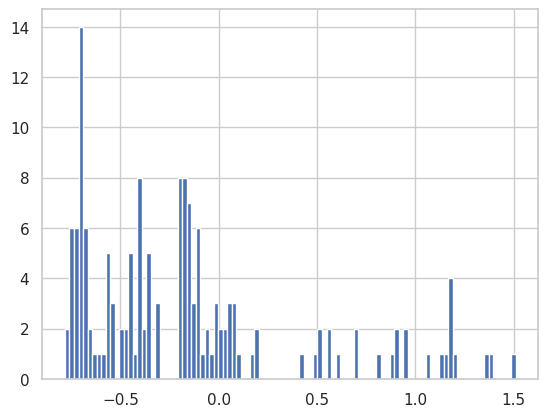

In [175]:
plt.hist(df_in.fold_change,  bins=100)

In [176]:

df_in['Polarization_group'] = 0
df_in

,Size,Dose,P_density,fold_change,Peptides,Polarization_group
0,HNP,1000,1.71,-0.71,CSKKKK,0
1,HNP,1000,1.71,-0.70,[QHREDGS],0
2,HNP,1000,1.71,-0.75,[RKDVY],0
3,HNP,1000,1.71,-0.76,[WKYMVM],0
4,HNP,1000,1.71,-0.69,[CLPFFD],0
...,...,...,...,...,...,...
149,HMP,100,4.99,0.07,[RKDVY],0
150,HMP,100,4.99,1.17,"[CSKKKK, QHREDGS]",0
151,HMP,100,4.99,-0.15,"[CSKKKK, RKDVY]",0
152,HMP,100,4.99,0.55,"[QHREDGS, RKDVY]",0


In [177]:
for i in range(len(df_in)):
  if df_in.fold_change[i]<0:
    df_in.Polarization_group[i] = 1
  elif df_in.fold_change[i]>0:
    df_in.Polarization_group[i] = 0

In [178]:
#df = df_in[['Size','Dose','P_density','CSKKKK','QHREDGS','RKDVY','WKYMVM','CLPFFD','QEINSSY','Polarization_group']]
df=df_in.drop(['fold_change'], axis=1)
df_in.head(5)

,Size,Dose,P_density,fold_change,Peptides,Polarization_group
0,HNP,1000,1.71,-0.71,CSKKKK,1
1,HNP,1000,1.71,-0.70,[QHREDGS],1
2,HNP,1000,1.71,-0.75,[RKDVY],1
3,HNP,1000,1.71,-0.76,[WKYMVM],1
4,HNP,1000,1.71,-0.69,[CLPFFD],1


In [179]:
df.at[0, 'Peptides']=['CSKKKK']
df

,Size,Dose,P_density,Peptides,Polarization_group
0,HNP,1000,1.71,[CSKKKK],1
1,HNP,1000,1.71,[QHREDGS],1
2,HNP,1000,1.71,[RKDVY],1
3,HNP,1000,1.71,[WKYMVM],1
4,HNP,1000,1.71,[CLPFFD],1
...,...,...,...,...,...
149,HMP,100,4.99,[RKDVY],0
150,HMP,100,4.99,"[CSKKKK, QHREDGS]",0
151,HMP,100,4.99,"[CSKKKK, RKDVY]",1
152,HMP,100,4.99,"[QHREDGS, RKDVY]",0


In [180]:
#encoding and scaling  #this one is in  FYP_final code_V3
#Simple way of encoding and scaling the object category and numeric columns without defining any piplines

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
# perform one-hot encoding on the 'col' and 'size' columns
mlb = MultiLabelBinarizer()
encoded_col = pd.DataFrame(mlb.fit_transform(df['Peptides']), columns=mlb.classes_)
encoded_size = pd.get_dummies(df['Size'])
df = pd.concat([df.drop(['Peptides', 'Size'], axis=1), encoded_col, encoded_size], axis=1)

# perform scaling on the 'Dose' and 'P_value' columns
scaler = StandardScaler()
scaled_Dose = scaler.fit_transform(df[['Dose']])
scaled_P_value = scaler.fit_transform(df[['P_density']])
df['Dose'] = scaled_Dose
df['P_density'] = scaled_P_value

# print the encoded and scaled dataframe
df

,Dose,P_density,Polarization_group,CLPFFD,CSKKKK,QEINSSY,QHREDGS,RKDVY,WKYMVM,HMP,HNP
0,1.00,-1.03,1,0,1,0,0,0,0,0,1
1,1.00,-1.03,1,0,0,0,1,0,0,0,1
2,1.00,-1.03,1,0,0,0,0,1,0,0,1
3,1.00,-1.03,1,0,0,0,0,0,1,0,1
4,1.00,-1.03,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
149,-1.00,-0.58,0,0,0,0,0,1,0,1,0
150,-1.00,-0.58,0,0,1,0,1,0,0,1,0
151,-1.00,-0.58,1,0,1,0,0,1,0,1,0
152,-1.00,-0.58,0,0,0,0,1,1,0,1,0


In [181]:
y = pd.DataFrame(df, columns=['Polarization_group']) 
X = df.drop(columns=['Polarization_group'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, #We put random state to keep the same selection
                                                    stratify=y) 
                             
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train
y_train
#X_train.to_csv('X_train.csv')
#y_train.to_csv('y_train.csv')

(128, 10)
(26, 10)
(128, 1)
(26, 1)


,Polarization_group
26,1
72,1
79,1
136,0
28,1
...,...
142,0
73,1
109,1
50,0


In [182]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)



(128, 10)
(26, 10)
(128, 1)
(26, 1)


In [183]:
! pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [184]:
# Import libraries
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

In [185]:
# Defines and builds the lazyclassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=matthews_corrcoef)
models_train,predictions_train = clf.fit(X_train, X_train, y_train, y_train)

100%|██████████| 29/29 [00:01<00:00, 15.56it/s]


In [186]:
# Prints the model performance (Training set)
models_train

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
LabelPropagation,1.00,1.00,1.00,1.00,1.00,0.04
RandomForestClassifier,1.00,1.00,1.00,1.00,1.00,0.20
DecisionTreeClassifier,1.00,1.00,1.00,1.00,1.00,0.03
ExtraTreeClassifier,1.00,1.00,1.00,1.00,1.00,0.03
ExtraTreesClassifier,1.00,1.00,1.00,1.00,1.00,0.16
LabelSpreading,1.00,1.00,1.00,1.00,1.00,0.04
BaggingClassifier,0.99,0.98,0.98,0.99,0.98,0.06
XGBClassifier,0.98,0.95,0.95,0.98,0.94,0.18
LGBMClassifier,0.88,0.81,0.81,0.88,0.68,0.12


In [187]:
models_test,predictions_test = clf.fit(X_train, X_test, y_train, y_test)
models_test

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:02<00:00, 14.32it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
AdaBoostClassifier,0.92,0.86,0.86,0.92,0.80,0.18
XGBClassifier,0.88,0.83,0.83,0.88,0.70,0.06
DecisionTreeClassifier,0.88,0.83,0.83,0.88,0.70,0.05
BaggingClassifier,0.85,0.80,0.80,0.85,0.61,0.08
LinearDiscriminantAnalysis,0.88,0.79,0.79,0.87,0.70,0.04
SVC,0.88,0.79,0.79,0.87,0.70,0.03
RidgeClassifierCV,0.88,0.79,0.79,0.87,0.70,0.04
RidgeClassifier,0.88,0.79,0.79,0.87,0.70,0.03
NuSVC,0.88,0.79,0.79,0.87,0.70,0.03


[(0.0, 1.0)]

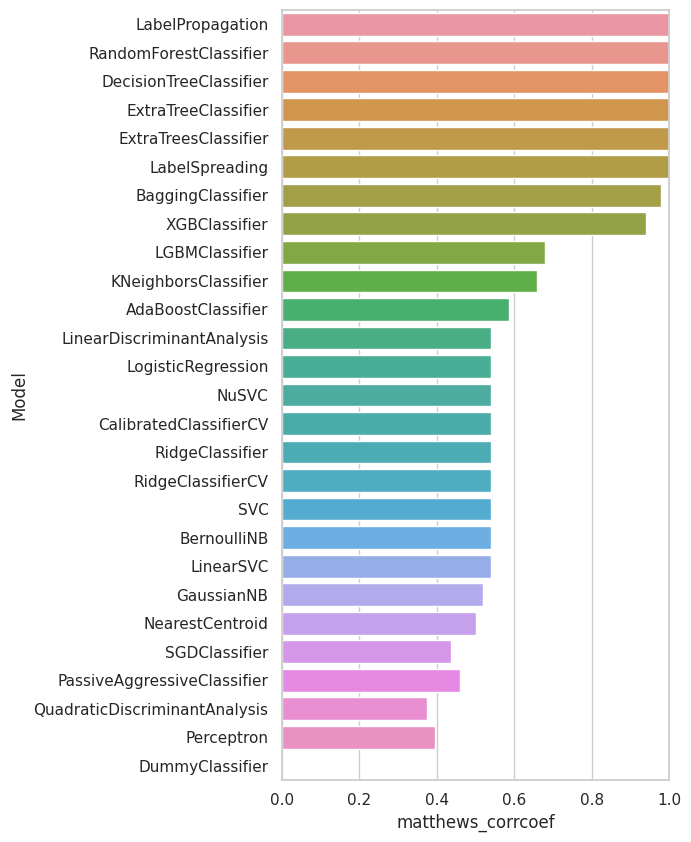

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models_train.index, x="matthews_corrcoef", data=models_train)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

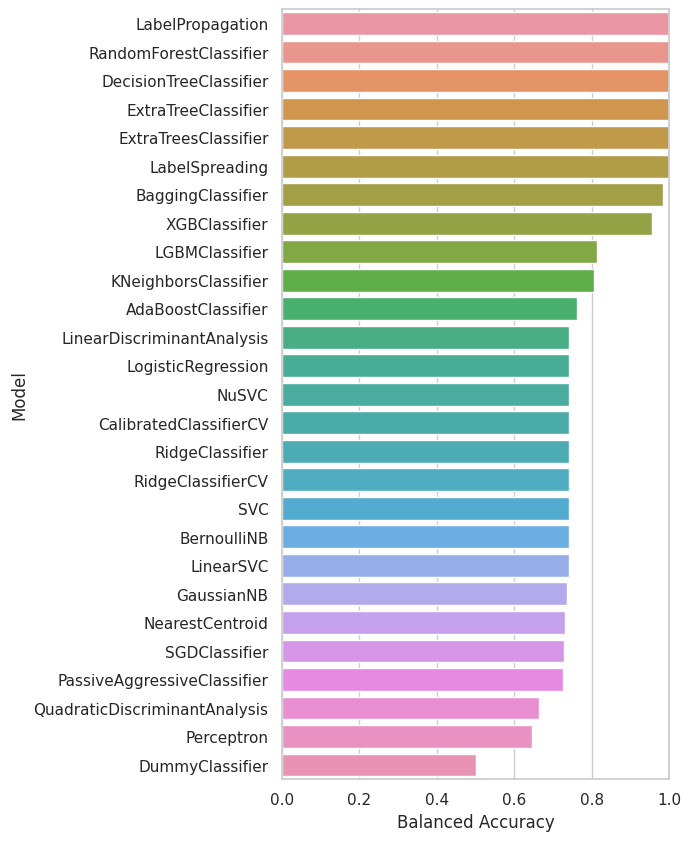

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models_train.index, x="Balanced Accuracy", data=models_train)
ax.set(xlim=(0, 1))

In [190]:
# Build random forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [191]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [192]:
rf.score(X_test,y_test)

0.8076923076923077

In [193]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.8076923076923077

In [194]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_test_pred)   #because the dataset is very imbalanced    balance accuracy is better to used as metrics


0.68796992481203

In [195]:
# Matthew Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_test_pred)

0.46217116665408475

In [196]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[ 3,  4],
       [ 1, 18]])

In [197]:
# Classification report
from sklearn.metrics import classification_report

model_report = classification_report(y_train, y_train_pred, target_names=['positive','negative'])

f = open('model_report.txt','w')
f.writelines(model_report) 
f.close()

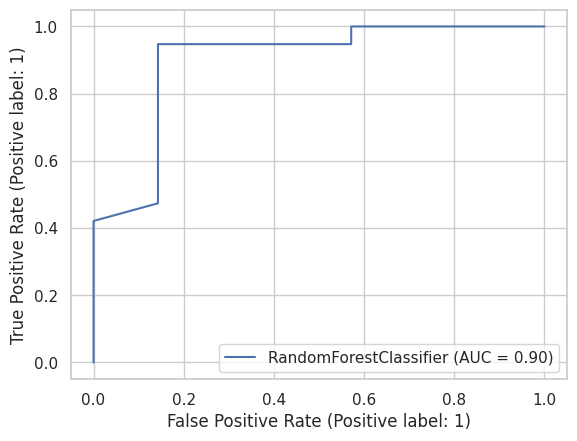

In [198]:
# ROC curve
# ROC curve    for sklearn from version 1.2 or newer
from sklearn.metrics import RocCurveDisplay
rf_disp_test = RocCurveDisplay.from_estimator(rf, X_test, y_test)

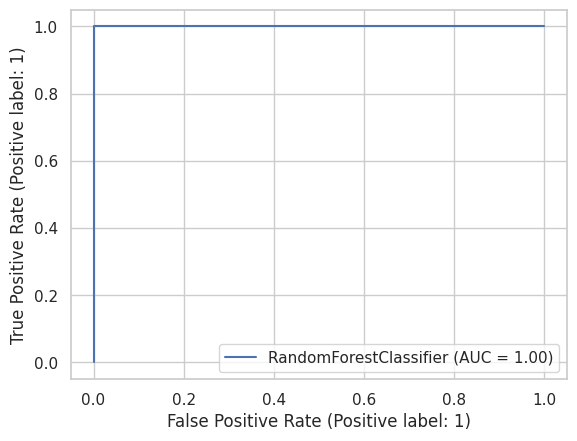

In [199]:
# ROC curve for train set
# ROC curve    for sklearn from version 1.2 or newer
from sklearn.metrics import RocCurveDisplay
rf_disp_test = RocCurveDisplay.from_estimator(rf, X_train, y_train)

In [200]:
# feature importance values
importance = pd.Series(rf.feature_importances_, name = 'Gini')

# feature names
feature_names = pd.Series(X_train.columns, name = 'Feature')

In [201]:
# Combine feature names and importance values into a Dataframe
df = pd.concat([feature_names, importance], axis=1, names=['Feature', 'Gini'])
df

,Feature,Gini
0,Dose,0.08
1,P_density,0.32
2,CLPFFD,0.06
3,CSKKKK,0.08
4,QEINSSY,0.05
5,QHREDGS,0.07
6,RKDVY,0.09
7,WKYMVM,0.04
8,HMP,0.10
9,HNP,0.11


Text(0.5, 0, 'Feature Importance')

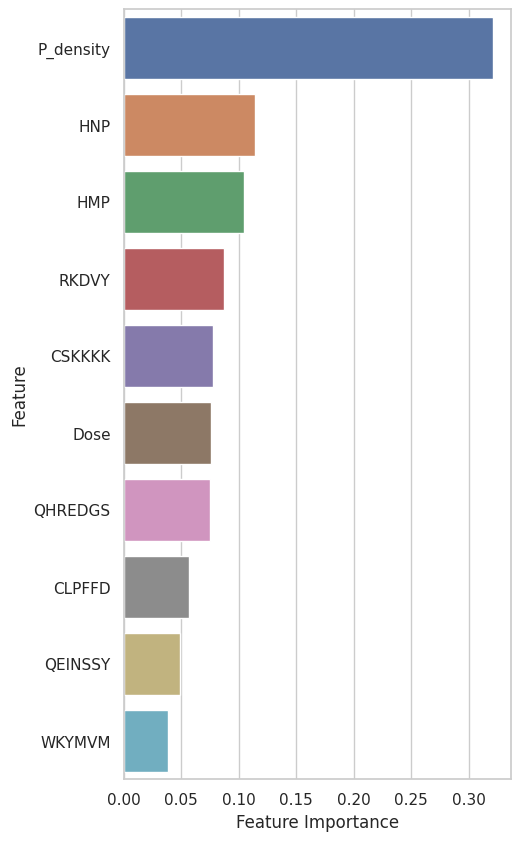

In [202]:
# feature importance plot
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False)[:] # Sort by Gini in descending order

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Feature', data = df_sorted)
plt.xlabel("Feature Importance")

In [203]:
#finish